## Import libraries

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

## Preparing the dataset environment

In [2]:
seed = 42
np.random.seed = seed

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

TRAIN_PATH = 'stage1_train/'
TEST_PATH = 'stage1_test/'

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


## Reading the train images

In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):   
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)  
            
    Y_train[n] = mask   


  0%|          | 0/670 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 670/670 [05:04<00:00,  2.20it/s]


## Reading the test images

In [4]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

  5%|▍         | 3/65 [00:00<00:02, 25.74it/s]

Resizing test images


100%|██████████| 65/65 [00:01<00:00, 45.42it/s]

Done!


## Let's see the images

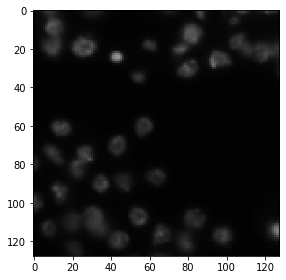

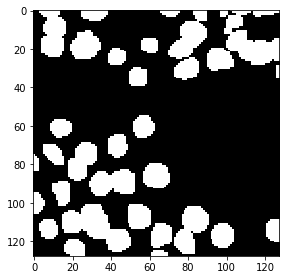

In [5]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

## U-Net Architecture for image segmentation

![U-Net Architecture](u-net-architecture.png "U-Net model")

# Helper functions for the architecture

In [6]:
def contrac_conv_block(inp, num_filt, kernel,activation, drop_rate, initializer = 'he_normal' ,padding = 'same'):
    c = tf.keras.layers.Conv2D(num_filt, kernel, activation=activation, kernel_initializer = initializer, padding = padding)(inp)
    c = tf.keras.layers.Dropout(drop_rate)(c)
    c = tf.keras.layers.Conv2D(num_filt, kernel, activation=activation, kernel_initializer = initializer, padding = padding)(c)
    return c


def expansive_conv_block(inp, encoder, num_filt,stride,  exp_kernel,contr_kernel, activation,drop_rate, initializer = 'he_normal' ,padding = 'same'):
    u = tf.keras.layers.Conv2DTranspose(num_filt, exp_kernel,strides = stride, padding=padding)(inp)
    u = tf.keras.layers.concatenate([u, encoder])
    c = tf.keras.layers.Conv2D(num_filt, contr_kernel , activation=activation, kernel_initializer=initializer, padding=padding)(u)
    c = tf.keras.layers.Dropout(drop_rate)(c)
    c = tf.keras.layers.Conv2D(num_filt, contr_kernel, activation=activation, kernel_initializer=initializer, padding=padding)(c)
    
    return c

## Builder function  for U-Net model

In [7]:
def build_Unet_model(scaled_inp):
    c1 = contrac_conv_block(inp = scaled_inp, num_filt = 16, kernel = (3,3),activation = 'relu', initializer = 'he_normal', padding = 'same', drop_rate = 0.1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = contrac_conv_block(inp = p1, num_filt = 32, kernel = (3,3),activation = 'relu', initializer = 'he_normal', padding = 'same', drop_rate = 0.1)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = contrac_conv_block(inp = p2, num_filt = 64, kernel = (3,3),activation = 'relu', initializer = 'he_normal', padding = 'same', drop_rate = 0.2)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = contrac_conv_block(inp = p3, num_filt = 128, kernel = (3,3),activation = 'relu', initializer = 'he_normal', padding = 'same', drop_rate = 0.2)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    
    c5 = contrac_conv_block(inp = p4, num_filt = 256, kernel = (3,3),activation = 'relu', initializer = 'he_normal', padding = 'same', drop_rate = 0.3)
    
    c6 = expansive_conv_block(inp = c5, encoder = c4, num_filt = 128, stride = (2,2), exp_kernel = (2,2), contr_kernel = (3,3),
                              activation = 'relu',initializer = 'he_normal' ,padding = 'same' , drop_rate = 0.2)
    c7 = expansive_conv_block(inp = c6, encoder = c3, num_filt = 64, stride = (2,2), exp_kernel = (2,2), contr_kernel = (3,3),
                              activation = 'relu',initializer = 'he_normal' ,padding = 'same' , drop_rate = 0.2)
    c8 = expansive_conv_block(inp = c7, encoder = c2, num_filt = 32, stride = (2,2), exp_kernel = (2,2), contr_kernel = (3,3),
                              activation = 'relu',initializer = 'he_normal' ,padding = 'same' , drop_rate = 0.1)
    c9 = expansive_conv_block(inp = c8, encoder = c1, num_filt = 16, stride = (2,2), exp_kernel = (2,2), contr_kernel = (3,3),
                              activation = 'relu',initializer = 'he_normal' ,padding = 'same' , drop_rate = 0.1)
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    return model

## Model initialization

In [8]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


model = build_Unet_model(s)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

## Define checkpoints and model fitting

In [9]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5', verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train, Y_train, validation_split=0.2, batch_size=32,verbose=2, epochs=50, callbacks=callbacks)


Epoch 1/50
17/17 - 40s - loss: 0.6238 - accuracy: 0.7793 - auc: 0.4222 - val_loss: 0.5068 - val_accuracy: 0.8035 - val_auc: 0.6169
Epoch 2/50
17/17 - 35s - loss: 0.4173 - accuracy: 0.8005 - auc: 0.7963 - val_loss: 0.2840 - val_accuracy: 0.8183 - val_auc: 0.9545
Epoch 3/50
17/17 - 39s - loss: 0.2774 - accuracy: 0.8547 - auc: 0.9360 - val_loss: 0.2282 - val_accuracy: 0.8968 - val_auc: 0.9592
Epoch 4/50
17/17 - 36s - loss: 0.2119 - accuracy: 0.9112 - auc: 0.9585 - val_loss: 0.1943 - val_accuracy: 0.9184 - val_auc: 0.9645
Epoch 5/50
17/17 - 39s - loss: 0.1690 - accuracy: 0.9362 - auc: 0.9729 - val_loss: 0.1478 - val_accuracy: 0.9408 - val_auc: 0.9789
Epoch 6/50
17/17 - 42s - loss: 0.1395 - accuracy: 0.9471 - auc: 0.9803 - val_loss: 0.1298 - val_accuracy: 0.9497 - val_auc: 0.9834
Epoch 7/50
17/17 - 45s - loss: 0.1261 - accuracy: 0.9511 - auc: 0.9839 - val_loss: 0.1113 - val_accuracy: 0.9571 - val_auc: 0.9875
Epoch 8/50
17/17 - 38s - loss: 0.1198 - accuracy: 0.9537 - auc: 0.9855 - val_loss: 

## Model evaluation

<Figure size 432x288 with 0 Axes>

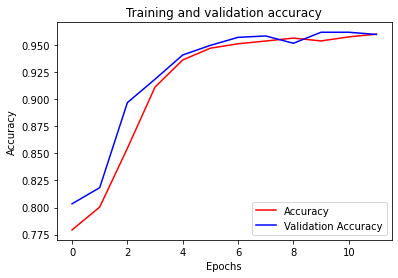

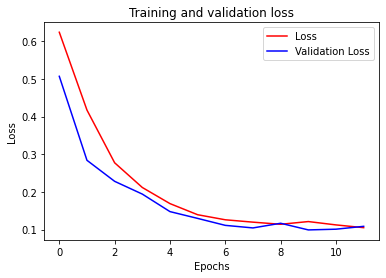

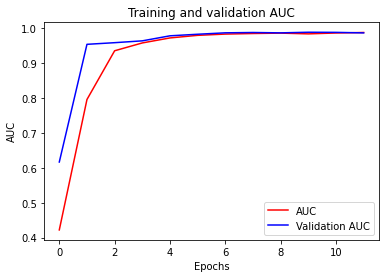

<Figure size 432x288 with 0 Axes>

In [12]:
acc=results.history['accuracy']
val_acc=results.history['val_accuracy']
loss=results.history['loss']
val_loss=results.history['val_loss']

auc = results.history['auc']
val_auc = results.history['val_auc']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

#------------------------------------------------
# Plot training and validation AUC per epoch
#------------------------------------------------
plt.plot(epochs, auc, 'r')
plt.plot(epochs, val_auc, 'b')
plt.title('Training and validation AUC')
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["AUC", "Validation AUC"])

plt.figure()

## Testing the predictions

3/3 [==============================] - 0s 112ms/step


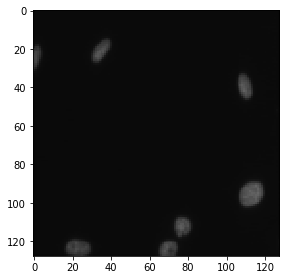

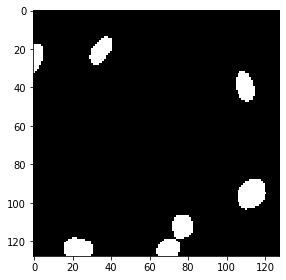

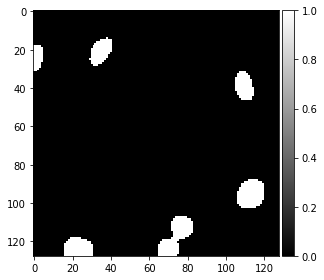

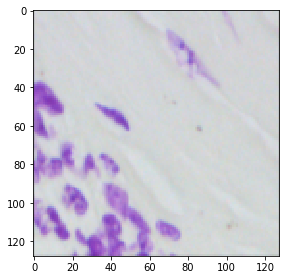

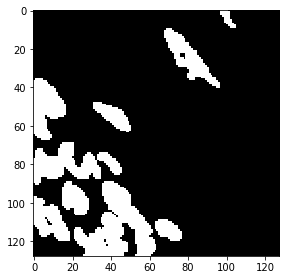

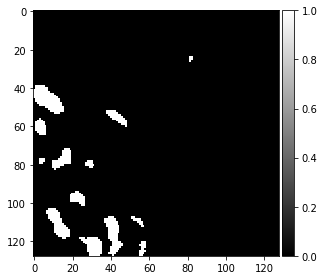

In [14]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]),cmap='gray')
plt.show()

# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]),cmap='gray')
plt.show()

## Extra: Model plot

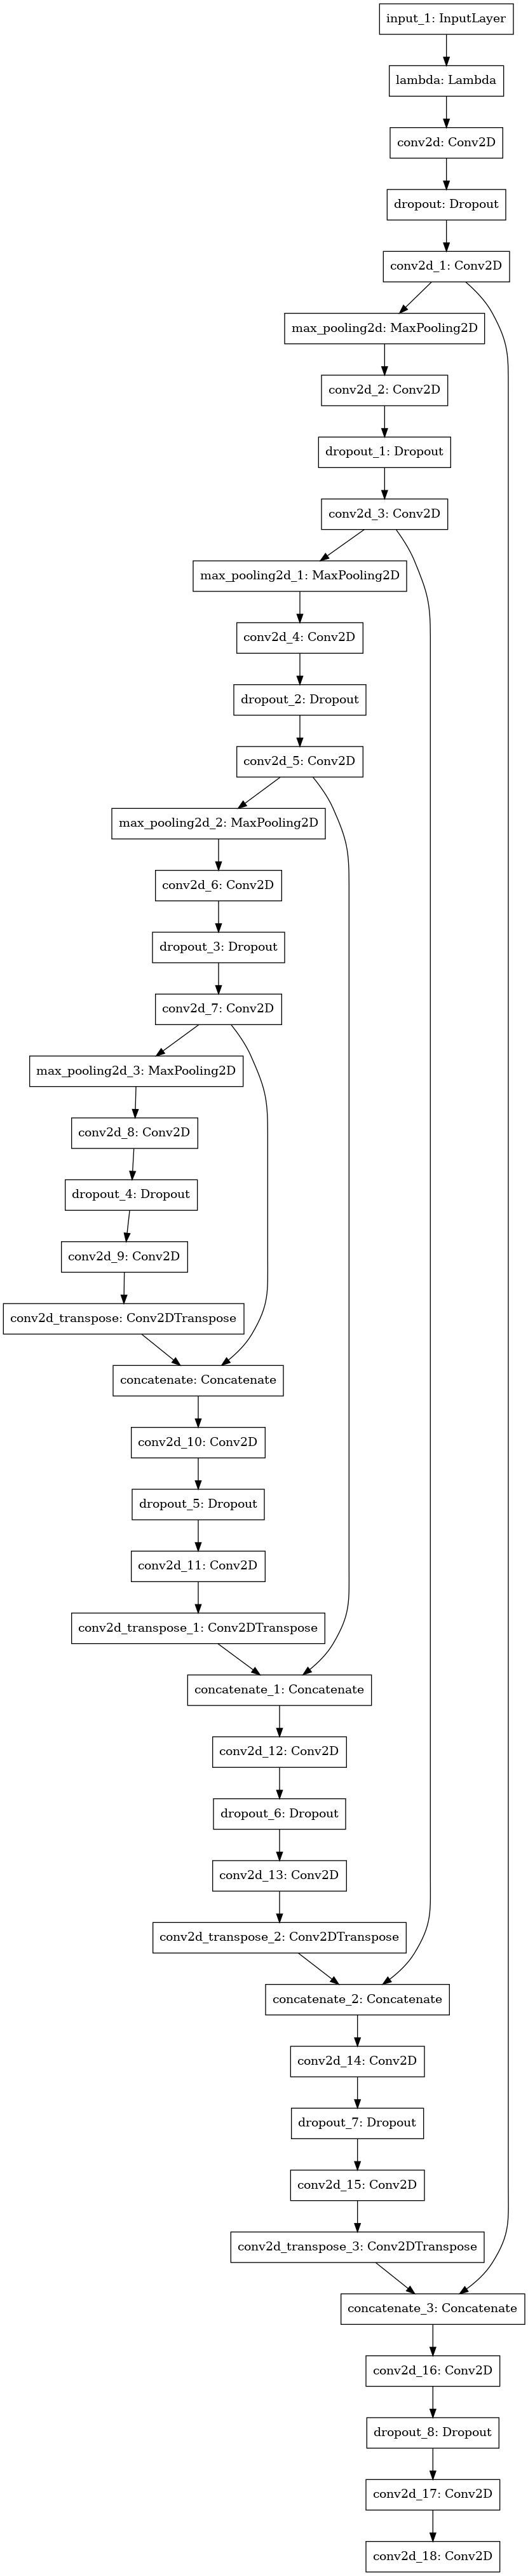

In [15]:
tf.keras.utils.plot_model(
    model,
    to_file="u-net.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)